# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import random
import datetime as dt
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

# Loading the excel files-Dates

In [2]:
dates_df = pd.read_csv("Dates.csv")
dates_df.head()
dates_df=dates_df.drop(["ICU_discharge"], axis=1)
dates_df.rename(columns = {'ser_num':'ID'}, inplace = True)
dates_df.head()

,ID,ICU_admission
0,8AF09E0A-B9B4-4903-B372-8EBC4B34664C,08/01/2011 14:51:00
1,2109B44D-7081-4329-B3FB-8DB7C44FF838,11/01/2011 04:45:00
2,9B638A86-4311-4F42-92FB-A38B0E8F0963,12/01/2011 18:54:00
3,DF624881-FF12-4153-9E58-28ACD76E6CCB,16/01/2011 15:17:00
4,FDEF86C4-10E4-49CF-8C01-AA9834718E3E,19/01/2011 10:07:00


In [3]:
dates_df['ICU_admission'] = dates_df['ICU_admission'].astype('datetime64') #changing date types

# Loading the excel files-Ree

In [351]:
xls = pd.ExcelFile(r"REE.xlsx")
Ree_df = pd.read_excel(xls, 'Sheet1')
Ree_df=Ree_df.drop(["PatientId","ParameterName","ValidationTime","ID_hash","ParameterID"], axis=1)
Ree_df.rename(columns = {'h_num_hash':'ID'}, inplace = True)

# Adding the date to the Ree DF

In [352]:
Ree_df = pd.merge(Ree_df, dates_df,  how='left', left_on=['ID'], right_on = ['ID'])

In [353]:
Ree_df.shape

(3430, 4)

#### size=3430

# Loading the excel files-Vital signs

In [7]:
xls = pd.ExcelFile(r"vital 2011.xlsx")
vitals2011_df = pd.read_excel(xls, 'VITAL SIGNS hash 2011')
xls = pd.ExcelFile(r"vital 2012.xlsx")
vitals2012_df = pd.read_excel(xls, 'VITAL SIGNS hash 2012')
xls = pd.ExcelFile(r"vital 2013.xlsx")
vitals2013_df = pd.read_excel(xls, 'VITAL SIGNS hash 2013')
xls = pd.ExcelFile(r"vital 2014.xlsx")
vitals2014_df = pd.read_excel(xls, 'VITAL SIGNS hash 2014')
xls = pd.ExcelFile(r"vital 2015.xlsx")
vitals2015_df = pd.read_excel(xls, 'VITAL SIGNS hash 2015')
xls = pd.ExcelFile(r"vital 2016.xlsx")
vitals2016_df = pd.read_excel(xls, 'VITAL SIGNS hash 2016')
xls = pd.ExcelFile(r"vital 2017.xlsx")
vitals2017_df = pd.read_excel(xls, 'VITAL SIGNS hash 2017')
xls = pd.ExcelFile(r"vital 2018.xlsx")
vitals2018_df = pd.read_excel(xls, 'Vital signs 2018')
#combining into one big df
vitals_df = pd.concat([vitals2011_df,vitals2012_df,vitals2013_df,vitals2014_df,vitals2015_df,vitals2016_df,vitals2017_df,vitals2018_df])
vitals_df=vitals_df.drop(["para_name"], axis=1)
vitals_df.rename(columns = {'h-num_demo':'ID'}, inplace = True)
vitals_df.rename(columns = {'value_demo':'value'}, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  if sys.path[0] == '':


In [8]:
vitals_df.head()

,ID,para_code,time,value
0,86E0AE1A-26BC-4791-A1C4-9747DD1B52A4,4704,2011-06-10 17:30:00,80.0
1,86E0AE1A-26BC-4791-A1C4-9747DD1B52A4,4704,2011-06-10 19:00:00,70.0
2,86E0AE1A-26BC-4791-A1C4-9747DD1B52A4,4704,2011-06-10 20:00:00,89.0
3,86E0AE1A-26BC-4791-A1C4-9747DD1B52A4,4704,2011-06-10 22:00:00,92.0
4,86E0AE1A-26BC-4791-A1C4-9747DD1B52A4,4704,2011-06-11 00:00:00,88.0


## Loading the Excel files-Weights

In [295]:
xls = pd.ExcelFile(r"weights.xlsx")
weight_df = pd.read_excel(xls, 'Sheet1')
weight_df.rename(columns = {'weight':'value'}, inplace = True)
weight_df=weight_df.rename(columns = {'Time':'time'})
weight_df=weight_df.rename(columns = {'ser_num':'ID'})
weight_df.head()

,ID,time,value
0,86E0AE1A-26BC-4791-A1C4-9747DD1B52A4,2011-06-10 17:42:00,85.0
1,248B8DB4-A4CE-4A00-BA7D-0453F77D12BA,2011-03-28 10:17:00,70.0
2,B2F09172-C954-4027-BEE8-500430BCF561,2011-11-20 03:24:00,75.0
3,87907BA8-D264-4632-B835-963DD68F2324,2012-01-09 15:38:00,51.0
4,87907BA8-D264-4632-B835-963DD68F2324,2012-01-09 18:48:00,51.0


# Arrange each vital sign in a data frame

In [367]:
df_4704=vitals_df[vitals_df['para_code'] == 4704] #hr דופק
df_7129=vitals_df[vitals_df['para_code'] == 7129] #temperature טמפרטורה
df_5966=vitals_df[vitals_df['para_code'] == 5966] #Urine Output תפוקת שתן
df_4727=vitals_df[vitals_df['para_code'] == 4727] #Central Venous Pressure לחץ ורידי מרכזי
df_4723=vitals_df[vitals_df['para_code'] == 4723] #Arterial Pressure Diastolic לחץ-דם דיאסטולי עורקי
df_5433=vitals_df[vitals_df['para_code'] == 5433] #Arterial Pressure Mean לחץ דם ממוצע עורקי

# Presenting the outliers

In [370]:
num_outliers_4704 = len(df_4704[df_4704['value'] < 20]) +  len(df_4704[df_4704['value'] > 250])
print('the number of rows in 4704 is', len(df_4704))
print('the number of outliers in 4704 is' , num_outliers_4704)
print()
num_outliers_4723 = len(df_4723[df_4723['value'] < 15]) +  len(df_4723[df_4723['value'] > 175])
print('the number of rows in 4723 is', len(df_4723))
print('the number of ouliers in 4723 is', num_outliers_4723)
print()
num_outliers_4727=len(df_4727[df_4727['value'] < 30]) +  len(df_4727[df_4727['value'] > 250])
print('the number of rows in 4727 is', len(df_4727))
print('the number of ouliers in 4727 is', num_outliers_4727)
print()
num_outliers_5433 = len(df_5433[df_5433['value'] < 15]) +  len(df_5433[df_5433['value'] > 200])
print('the number of rows in 5433 is', len(df_5433))
print('the number of ouliers in 5433 is', num_outliers_5433)
print()
num_outliers_7129 = len(df_7129[df_7129['value'] < 32]) +  len(df_7129[df_7129['value'] > 44])
print('the number of rows in 7129 is', len(df_7129))
print('the number of ouliers in 7129 is', num_outliers_7129)
print()
num_outliers_5966 = len(df_5966[df_5966['value'] < 0]) +  len(df_5966[df_5966['value'] > 1500])
print('the number of rows in 5966 is', len(df_5966))
print('the number of ouliers in 5966 is', num_outliers_5966)
print()
num_outliers_weight = len(weight_df[weight_df['value'] < 0.5]) +  len(weight_df[weight_df['value'] > 300])
print('the number of rows in weights is', len(weight_df))
print('the number of ouliers in weight is', num_outliers_weight)
print()
num_outliers_REE = len(Ree_df[Ree_df['Value'] < 300]) +  len(Ree_df[Ree_df['Value'] > 5000])
print('the number of rows in REE is', len(Ree_df))
print('the number of ouliers in REE is', num_outliers_REE)

the number of rows in 4704 is 846705
the number of outliers in 4704 is 0

the number of rows in 4723 is 735602
the number of ouliers in 4723 is 0

the number of rows in 4727 is 735790
the number of ouliers in 4727 is 0

the number of rows in 5433 is 731874
the number of ouliers in 5433 is 0

the number of rows in 7129 is 836962
the number of ouliers in 7129 is 0

the number of rows in 5966 is 785867
the number of ouliers in 5966 is 0

the number of rows in weights is 7226
the number of ouliers in weight is 0

the number of rows in REE is 3430
the number of ouliers in REE is 0


# Removing the outliers

In [369]:
df_4704.loc[df_4704.value > 250, 'value'] = np.nan
df_4704.loc[df_4704.value < 20, 'value'] = np.nan

df_4723.loc[df_4723.value > 175, 'value'] = np.nan
df_4723.loc[df_4723.value < 15, 'value'] = np.nan

df_4727.loc[df_4727.value > 250, 'value'] = np.nan
df_4727.loc[df_4727.value < 30, 'value'] = np.nan

df_5433.loc[df_5433.value > 200, 'value'] = np.nan
df_5433.loc[df_5433.value < 15, 'value'] = np.nan

df_7129.loc[df_7129.value > 44, 'value'] = np.nan
df_7129.loc[df_7129.value < 32, 'value'] = np.nan

df_5966.loc[df_5966.value > 1500, 'value'] = np.nan
df_5966.loc[df_5966.value < 0, 'value'] = np.nan

weight_df.loc[weight_df.value > 300, 'value'] = np.nan
weight_df.loc[weight_df.value < 0.5, 'value'] = np.nan

Ree_df.loc[Ree_df.Value > 5000, 'Value'] = np.nan
Ree_df.loc[Ree_df.Value < 300, 'Value'] = np.nan

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Understanding the dataframes we created for each vital and for the REE

In [371]:
Ree_df.shape

(3430, 4)

In [372]:
df_5966.head()

,ID,para_code,time,value
339,86E0AE1A-26BC-4791-A1C4-9747DD1B52A4,5966,2011-06-10 18:00:00,50.0
340,86E0AE1A-26BC-4791-A1C4-9747DD1B52A4,5966,2011-06-10 23:00:00,250.0
341,86E0AE1A-26BC-4791-A1C4-9747DD1B52A4,5966,2011-06-11 02:00:00,70.0
342,86E0AE1A-26BC-4791-A1C4-9747DD1B52A4,5966,2011-06-11 06:00:00,100.0
343,86E0AE1A-26BC-4791-A1C4-9747DD1B52A4,5966,2011-06-11 08:00:00,50.0


# Merging the dataframes

In [373]:
df_7129=df_7129.sort_values(by='time')
df_5966=df_5966.sort_values(by='time')
df_4727=df_4727.sort_values(by='time')
df_4723=df_4723.sort_values(by='time')
df_5433=df_5433.sort_values(by='time')
df_4704=df_4704.sort_values(by='time')
weight_df=weight_df.sort_values(by='time')
Ree_df=Ree_df.rename(columns = {'Time':'time'})
Ree_df=Ree_df.sort_values(by='time')

## Created a Merge based on the nearset time with a time limit of 30 minutes before OR after 

In [374]:
Ree_df=pd.merge_asof(Ree_df, df_7129, on="time", by="ID", tolerance=pd.Timedelta("30m"),direction="nearest")
Ree_df=Ree_df.drop(["para_code"],axis=1)
Ree_df=Ree_df.rename(columns = {'value':'7129'})

Ree_df=pd.merge_asof(Ree_df, df_5966, on="time", by="ID", tolerance=pd.Timedelta("30m"),direction="nearest")
Ree_df=Ree_df.drop(["para_code"],axis=1)
Ree_df=Ree_df.rename(columns = {'value':'5966'})

Ree_df=pd.merge_asof(Ree_df, df_4727, on="time", by="ID", tolerance=pd.Timedelta("30m"),direction="nearest")
Ree_df=Ree_df.drop(["para_code"],axis=1)
Ree_df=Ree_df.rename(columns = {'value':'4727'})

Ree_df=pd.merge_asof(Ree_df, df_4723, on="time", by="ID", tolerance=pd.Timedelta("30m"),direction="nearest")
Ree_df=Ree_df.drop(["para_code"],axis=1)
Ree_df=Ree_df.rename(columns = {'value':'4723'})

Ree_df=pd.merge_asof(Ree_df, df_5433, on="time", by="ID", tolerance=pd.Timedelta("30m"),direction="nearest")
Ree_df=Ree_df.drop(["para_code"],axis=1)
Ree_df=Ree_df.rename(columns = {'value':'5433'})

Ree_df=pd.merge_asof(Ree_df, df_4704, on="time", by="ID", tolerance=pd.Timedelta("30m"),direction="nearest")
Ree_df=Ree_df.drop(["para_code"],axis=1)
Ree_df=Ree_df.rename(columns = {'value':'4704'})

Ree_df=pd.merge_asof(Ree_df, weight_df, on="time", by="ID", tolerance=pd.Timedelta("36 days"),direction="nearest")
Ree_df=Ree_df.rename(columns = {'value':'Weight'})

In [375]:
Ree_df = Ree_df.sort_values(by = ['time'])


# Building the Hour Counter

In [376]:
Ree_df['Hour_counter'] = (Ree_df['time'] - Ree_df['ICU_admission']).dt.total_seconds() / 60 / 60

# Adding Names to each column

In [377]:
Ree_df.rename(columns={'Value': 'REE'}, inplace=True)
Ree_df.rename(columns={'7129': 'Temperature'}, inplace=True)
Ree_df.rename(columns={'5966': 'Urine_Output'}, inplace=True)
Ree_df.rename(columns={'4727': 'Central_VP'}, inplace=True)
Ree_df.rename(columns={'4723': 'Arterial_PD'}, inplace=True)
Ree_df.rename(columns={'5433': 'Arterial_PM'}, inplace=True)
Ree_df.rename(columns={'4704': 'Heart_Rate'}, inplace=True)

# Final data frame

In [378]:
Ree_df.head()

,ID,time,REE,ICU_admission,Temperature,Urine_Output,Central_VP,Arterial_PD,Arterial_PM,Heart_Rate,Weight,Hour_counter
0,0710509B-A470-4EF0-96D7-14E3F1A070FF,2011-02-06 12:33:00,1580.0,2011-05-02 11:20:00,35.74,30.0,117.00000,54.0,76.99998,53.0,80.0,-2038.783333
1,E24C1D0A-3812-48A0-BAF9-32181A4AF66E,2011-02-11 10:10:00,2290.0,2011-07-02 00:20:00,37.87,100.0,155.00000,67.0,91.00003,122.0,52.0,-3374.166667
2,5A339884-E1D0-496B-B655-9B9599BB09C2,2011-02-12 10:29:00,2350.0,2011-06-02 15:41:00,37.43,50.0,92.00002,40.0,56.00000,109.0,100.0,-2645.200000
3,C30AE4EF-BE53-4CFA-8D59-D93C81C2BE73,2011-02-13 15:00:00,1540.0,2011-10-02 16:10:00,35.88,50.0,116.00000,52.0,72.00000,75.0,115.0,-5545.166667
4,C30AE4EF-BE53-4CFA-8D59-D93C81C2BE73,2011-02-13 15:00:00,1540.0,2011-04-21 00:37:00,35.88,50.0,116.00000,52.0,72.00000,75.0,115.0,-1593.616667


In [385]:
Ree_df.describe()

,REE,Temperature,Urine_Output,Central_VP,Arterial_PD,Arterial_PM,Heart_Rate,Weight,Hour_counter
count,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000
mean,1971.231485,37.175804,90.762659,127.971065,60.584223,82.203583,92.660007,83.874027,-135.612688
std,543.397867,0.903107,70.282681,27.684196,15.993162,17.919596,20.672960,24.216610,2361.953400
min,690.000000,32.370000,0.000000,34.000000,25.000000,30.000000,31.000000,35.000000,-7756.150000
25%,1580.000000,36.630010,50.000000,108.000000,50.000000,69.000000,78.000000,70.000000,-191.841667
50%,1910.000000,37.210000,70.000000,124.000000,59.000000,79.000020,92.000000,80.000000,100.633333
75%,2280.000000,37.800000,100.000000,145.000000,68.000000,92.000020,106.000000,94.000000,378.733333
max,4510.000000,40.510000,580.000000,235.000000,175.000000,178.000000,250.000000,232.000000,7998.233333


In [386]:
Ree_df=Ree_df.dropna()

In [387]:
Ree_df.shape

(2903, 12)

After dropping Rows with empty data we lose about 15% of our entries. <br>
Considering the scale of the data that sound like a large number but given the fact that the data is 10 or more years old it's not surprising

In [388]:
features = ['REE', 'Temperature', 'Urine_Output', 'Central_VP', 'Arterial_PD', 'Arterial_PM',
       'Heart_Rate',"Weight"]

# Heatmap

<AxesSubplot:>

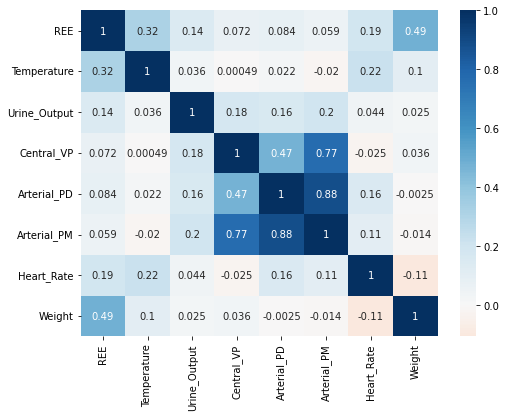

In [389]:
corrs = Ree_df[features].corr(method = 'pearson')
plt.figure(figsize=(8,6))  #figure size
sns.heatmap(corrs, cmap='RdBu', center=0, annot = True )

# Boxplots

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='REE'>

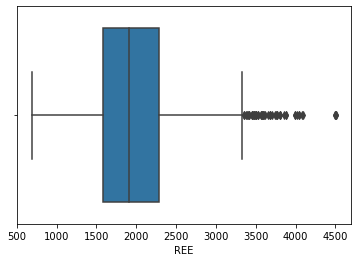

In [390]:
sns.boxplot(Ree_df['REE'])

Temperature        AxesSubplot(0.125,0.657941;0.227941x0.222059)
Urine_Output    AxesSubplot(0.398529,0.657941;0.227941x0.222059)
Heart_Rate      AxesSubplot(0.672059,0.657941;0.227941x0.222059)
Central_VP         AxesSubplot(0.125,0.391471;0.227941x0.222059)
Arterial_PD     AxesSubplot(0.398529,0.391471;0.227941x0.222059)
Arterial_PM     AxesSubplot(0.672059,0.391471;0.227941x0.222059)
Weight                AxesSubplot(0.125,0.125;0.227941x0.222059)
dtype: object

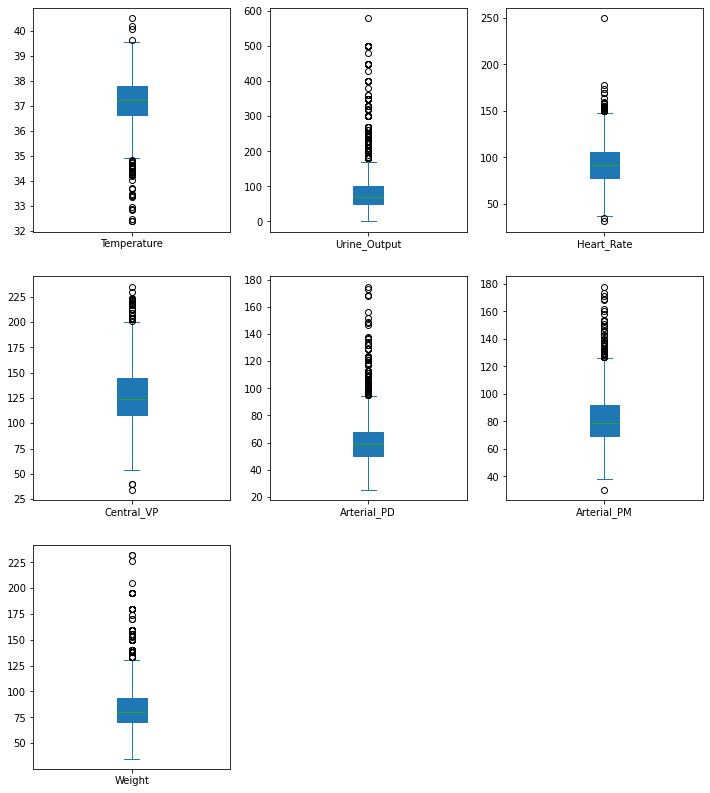

In [456]:
Ree_df[['Temperature', 'Urine_Output','Heart_Rate','Central_VP', 'Arterial_PD', 'Arterial_PM','Weight']].plot(subplots=True, layout=(3,3), kind='box', figsize=(12,14), patch_artist=True)

### Showing the Diffrence between weight categories in REE

<Figure size 64000x12000 with 0 Axes>

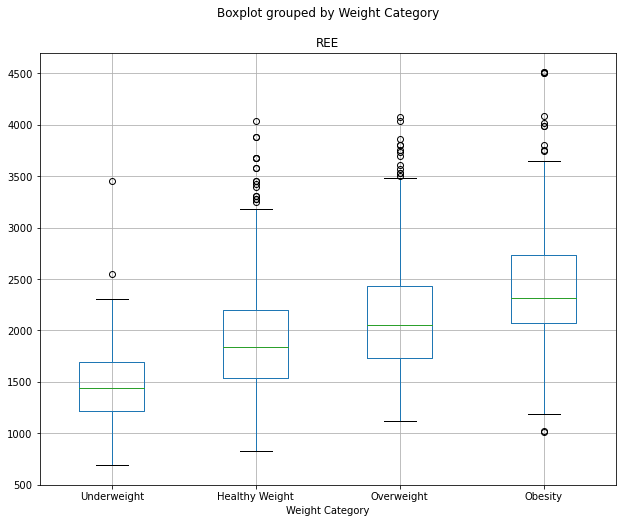

<Figure size 64000x12000 with 0 Axes>

In [474]:
weight_categories = ['Underweight', 'Healthy Weight', 'Overweight', 'Obesity']
# Create a new column in the DataFrame for the weight categories
Ree_df['Weight Category'] = pd.cut(Ree_df['Weight'], bins=[0, 58, 88, 117,500], labels=weight_categories, include_lowest=True)

# Create a box plot for the REE column, while dividing the DataFrame by the weight categories
Ree_df.boxplot(column='REE', by='Weight Category',figsize=(10,8))

# Scatter plots

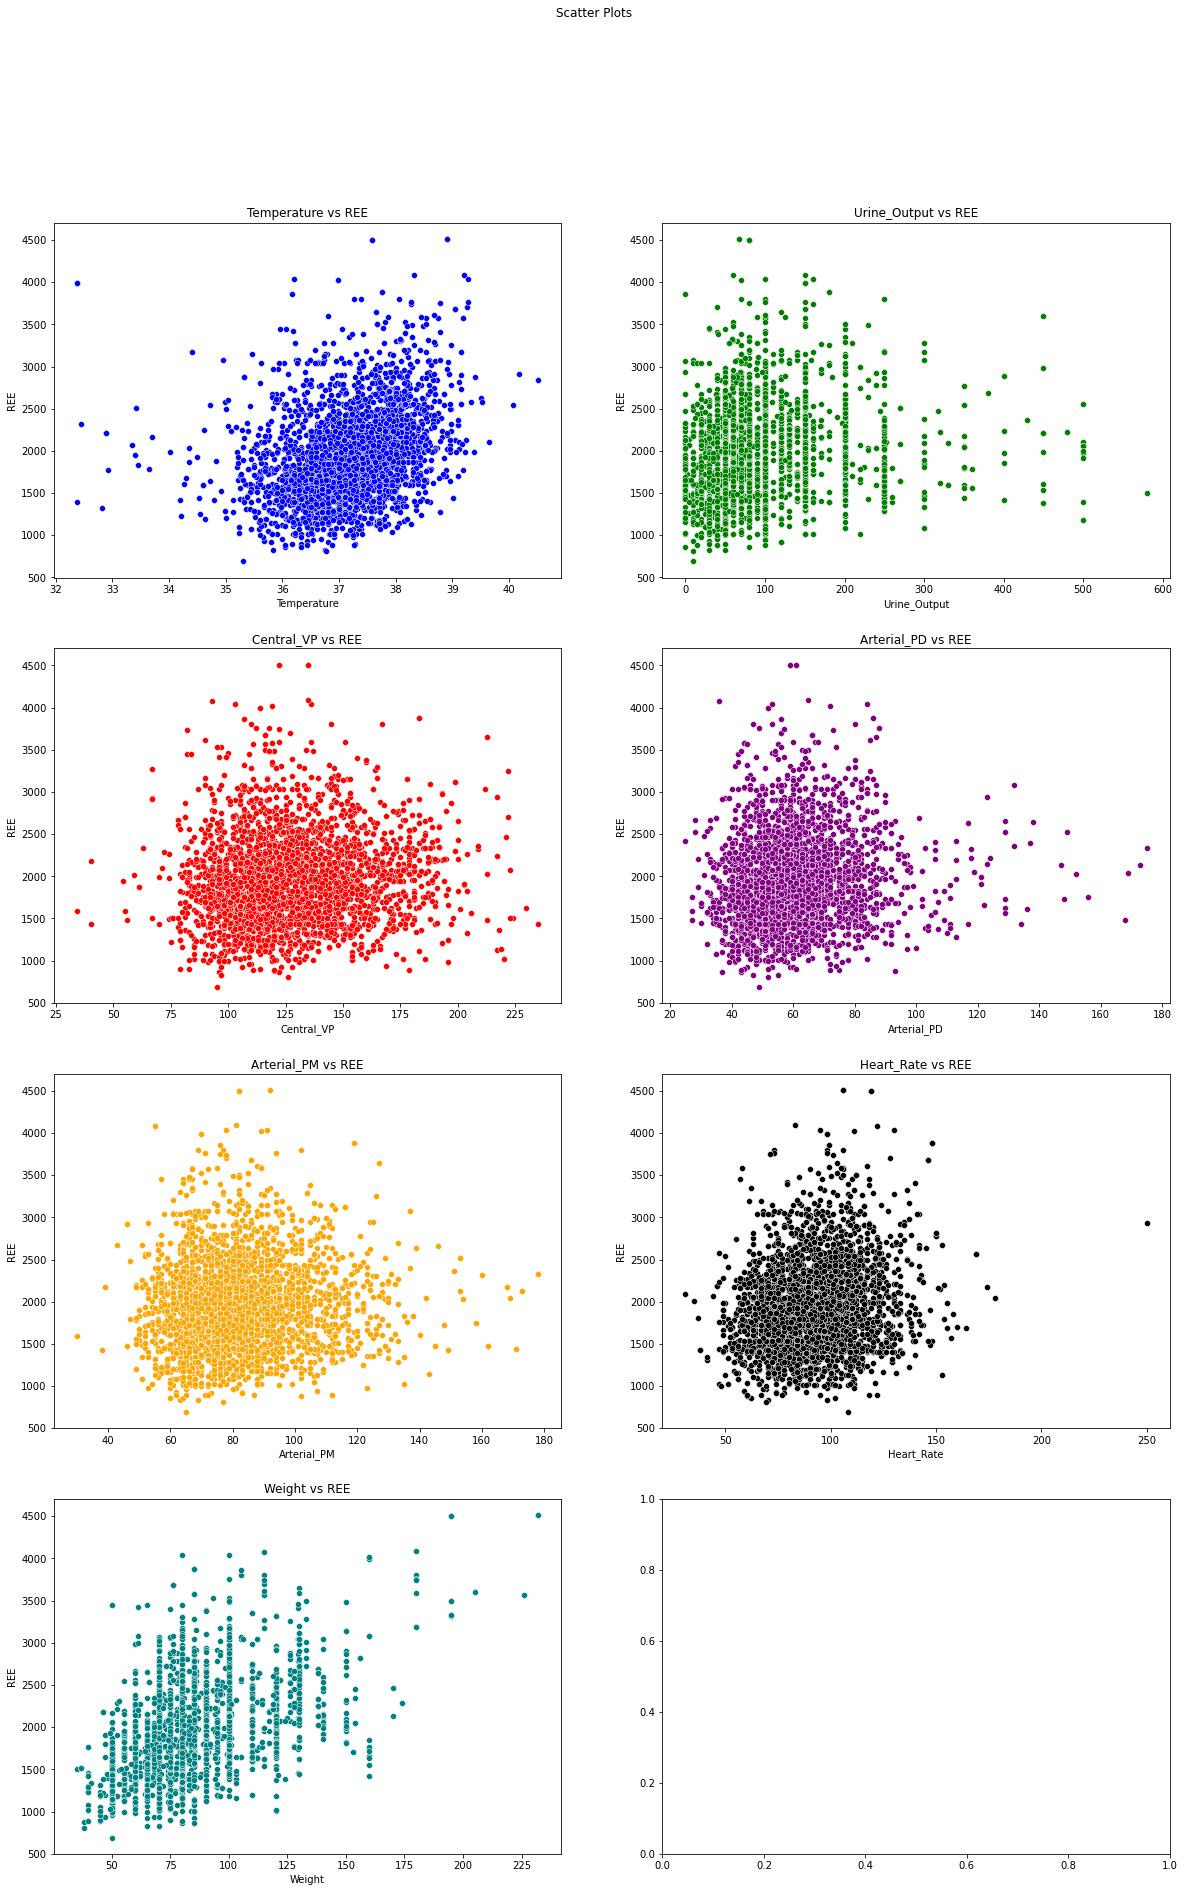

In [413]:
fig, axs = plt.subplots(4, 2, figsize=(20, 30))

sns.scatterplot(x='Temperature', y='REE', data=Ree_df, ax=axs[0][0],sizes=(3, 3), color="blue")
sns.scatterplot(x='Urine_Output', y='REE', data=Ree_df, ax=axs[0][1],sizes=(3, 3), color="green")
sns.scatterplot(x='Central_VP', y='REE', data=Ree_df, ax=axs[1][0],sizes=(3, 3), color="red")
sns.scatterplot(x='Arterial_PD', y='REE', data=Ree_df, ax=axs[1][1],sizes=(3, 3), color="purple")
sns.scatterplot(x='Arterial_PM', y='REE', data=Ree_df, ax=axs[2][0],sizes=(3, 3), color="orange")
sns.scatterplot(x='Heart_Rate', y='REE', data=Ree_df, ax=axs[2][1],sizes=(3, 3), color="black")
sns.scatterplot(x='Weight', y='REE', data=Ree_df, ax=axs[3][0],sizes=(3, 3), color="teal")

plt.suptitle('Scatter Plots')

axs[0][0].set_title('Temperature vs REE')
axs[0][1].set_title('Urine_Output vs REE')
axs[1][0].set_title('Central_VP vs REE')
axs[1][1].set_title('Arterial_PD vs REE')
axs[2][0].set_title('Arterial_PM vs REE')
axs[2][1].set_title('Heart_Rate vs REE')
axs[3][0].set_title('Weight vs REE')

plt.show()

In [401]:
axs

array([[<AxesSubplot:xlabel='ID', ylabel='REE'>,
        <AxesSubplot:xlabel='time', ylabel='REE'>,
        <AxesSubplot:xlabel='REE', ylabel='REE'>],
       [<AxesSubplot:xlabel='ICU_admission', ylabel='REE'>,
        <AxesSubplot:xlabel='Temperature', ylabel='REE'>,
        <AxesSubplot:xlabel='Urine_Output', ylabel='REE'>]], dtype=object)

# Distribution plots

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

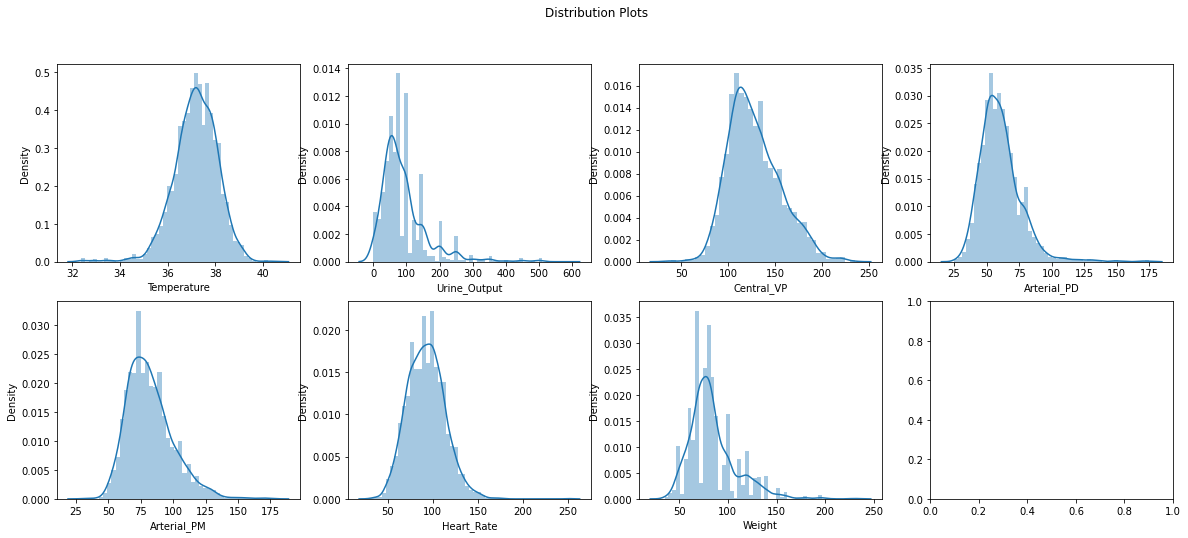

In [420]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
sns.distplot(Ree_df['Temperature'], ax=axs[0][0])
sns.distplot(Ree_df['Urine_Output'], ax=axs[0][1])
sns.distplot(Ree_df['Central_VP'], ax=axs[0][2])
sns.distplot(Ree_df['Arterial_PD'], ax=axs[0][3])
sns.distplot(Ree_df['Arterial_PM'], ax=axs[1][0])
sns.distplot(Ree_df['Heart_Rate'], ax=axs[1][1])
sns.distplot(Ree_df['Weight'], ax=axs[1][2])
plt.suptitle('Distribution Plots')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='REE', ylabel='Density'>

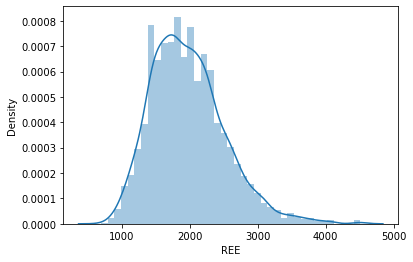

In [421]:
sns.distplot(Ree_df['REE'])

# Machine Learning models

In [434]:
#Spliting the data in to train and test data
x = Ree_df[['Temperature', 'Urine_Output','Heart_Rate','Central_VP', 'Arterial_PD', 'Arterial_PM','Weight']]
y = Ree_df['REE']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

We tried removing some variables.<br> The removal method was removing them one by one based on the highest VIF every time and examining the results.<br> the process left us with only the Temperature and Urine_Output.<br> For now, it's hard to say whether our data isn't useful or just because it's the human body it's hard to determine, this requires further investigation.

In [433]:
vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i)
                          for i in range(len(x.columns))]
vif_data

,feature,VIF
0,Urine_Output,2.401089
1,Weight,2.401089


In [432]:
x=x.drop(vif_data.min(axis=0)[0],axis=1)
x

,Urine_Output,Weight
0,30.0,80.0
1,100.0,52.0
2,50.0,100.0
3,50.0,115.0
4,50.0,115.0
...,...,...
3420,90.0,75.0
3425,0.0,100.0
3427,80.0,85.0
3428,30.0,40.0


# LinearRegression model

In [436]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
print("Linear Regression MSE: ", mse)
print("Linear Regression R2: ", r2)
print("Linear Regression MAE: ", mae)
print("Linear Regression EVS: ", evs)

Linear Regression MSE:  171826.85731758122
Linear Regression R2:  0.3155406866637942
Linear Regression MAE:  326.7198818089573
Linear Regression EVS:  0.31712483234824196


### Extreme variance was noticed between the results when changing the part the data was taken from,<br>this perhapes can be a result of the small amount of data.<br> We will check using kfolds next.

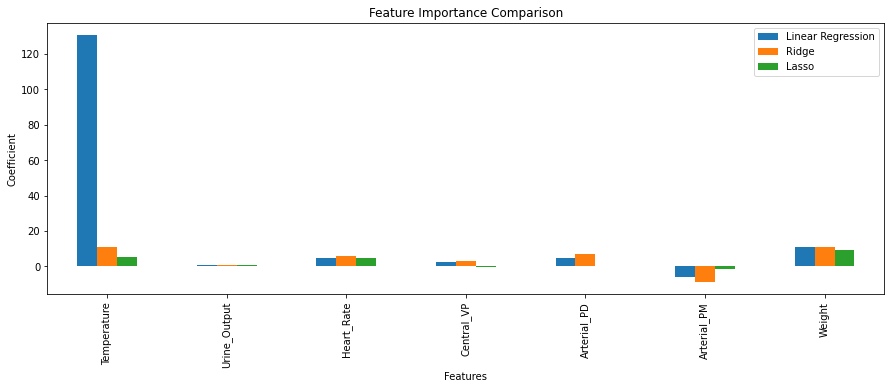

In [439]:
# fit the linear regression model
model_lr = sm.OLS(y, sm.add_constant(x)).fit()

# fit the ridge model
model_ridge = sm.OLS(y, sm.add_constant(x)).fit_regularized(alpha=0.5, L1_wt=0)

# fit the lasso model
model_lasso = sm.OLS(y, sm.add_constant(x)).fit_regularized(alpha=0.5, L1_wt=1)

# create a dataframe with the feature importance for each model
df = pd.DataFrame({
    "Linear Regression": model_lr.params[1:],
    "Ridge": model_ridge.params[1:],
    "Lasso": model_lasso.params[1:]
})

# plot the feature importance
df.plot(kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.title("Feature Importance Comparison")
plt.gcf().set_size_inches(15,5)
plt.show()

In [440]:
print_model = model_lr.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                    REE   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     232.4
Date:                Sun, 18 Jun 2023   Prob (F-statistic):          9.29e-275
Time:                        17:20:27   Log-Likelihood:                -21754.
No. Observations:                2903   AIC:                         4.352e+04
Df Residuals:                    2895   BIC:                         4.357e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -4432.8761    341.221    -12.991   

# RidgeRegression model

In [441]:
ridge = Ridge()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(ridge, param_grid, cv=5)
grid_search.fit(x_train, y_train)
print("Best alpha: ", grid_search.best_params_)

Best alpha:  {'alpha': 10}


In [442]:
# Ridge Regression
ridge = Ridge(alpha=grid_search.best_params_.get('alpha'))
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
print("Ridge Regression MSE: ", mse)
print("Ridge Regression R2: ", r2)
print("Ridge Regression MAE: ", mae)
print("Ridge Regression EVS: ", evs)

Ridge Regression MSE:  171795.45404570206
Ridge Regression R2:  0.31566577922640326
Ridge Regression MAE:  326.6810809840343
Ridge Regression EVS:  0.31724906198972935


Feature: Temperature, Score: 135.49428
Feature: Urine_Output, Score: 0.83211
Feature: Heart_Rate, Score: 4.92229
Feature: Central_VP, Score: 2.25086
Feature: Arterial_PD, Score: 4.78862
Feature: Arterial_PM, Score: -5.31054
Feature: Weight, Score: 10.91095


<BarContainer object of 7 artists>

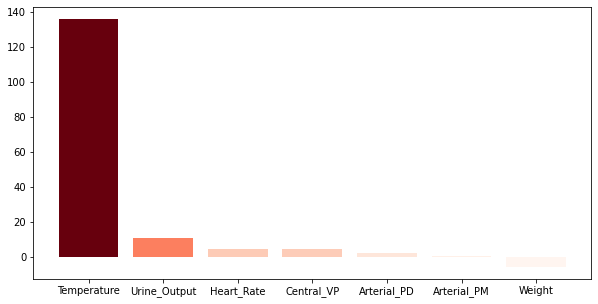

In [443]:
importanceR = ridge.coef_
#summarize feature importance
for i in range(len(importanceR)):
    print('Feature: %0s, Score: %.5f' % (x_train.columns[i],importanceR[i]))
features = pd.Series(importanceR).sort_values(ascending=False)
# Create a bar plot
fig, ax = plt.subplots()
plt.gcf().set_size_inches(10,5)
ax.bar(x_train.columns, features, color=plt.cm.Reds(features.values/25))

# Lasso Regression model

In [444]:
lasso = LassoCV()
lasso.fit(x_train, y_train)
print("Best alpha: ", lasso.alpha_)

Best alpha:  6.573607286480436


In [445]:

lasso = Lasso(alpha=lasso.alpha_)
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
print("Lasso Regression MSE: ", mse)
print("Lasso Regression R2: ", r2)
print("Lasso Regression MAE: ", mae)
print("Lasso Regression EVS: ", evs)

Lasso Regression MSE:  171557.3979174339
Lasso Regression R2:  0.3166140578403148
Lasso Regression MAE:  326.47019620680214
Lasso Regression EVS:  0.3181844887792431


Feature: Temperature, Score: 128.05973
Feature: Urine_Output, Score: 0.83345
Feature: Heart_Rate, Score: 4.98814
Feature: Central_VP, Score: 2.11309
Feature: Arterial_PD, Score: 4.42337
Feature: Arterial_PM, Score: -4.84857
Feature: Weight, Score: 10.94533


<BarContainer object of 7 artists>

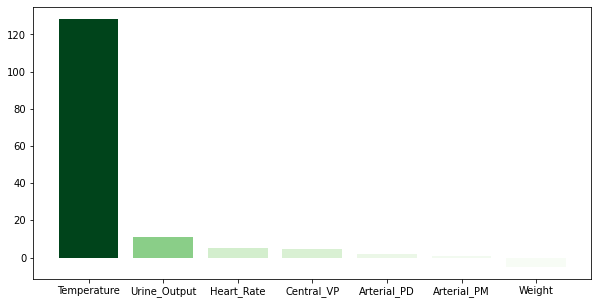

In [446]:
importanceR = lasso.coef_
#summarize feature importance
for i in range(len(importanceR)):
    print('Feature: %0s, Score: %.5f' % (x_train.columns[i],importanceR[i]))
features = pd.Series(importanceR).sort_values(ascending=False)
# Create a bar plot
fig, ax = plt.subplots()
plt.gcf().set_size_inches(10,5)
ax.bar(x_train.columns, features, color=plt.cm.Greens(features.values/25))

# Random Forest Regression

In [447]:

random_forest = RandomForestRegressor()
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
print("Random Forest Regression MSE: ", mse)
print("Random Forest Regression R2: ", r2)
print("Random Forest Regression MAE: ", mae)
print("Random Forest Regression EVS: ", evs)

Random Forest Regression MSE:  164111.21877631513
Random Forest Regression R2:  0.346275350268475
Random Forest Regression MAE:  303.29677813293995
Random Forest Regression EVS:  0.346774365110022


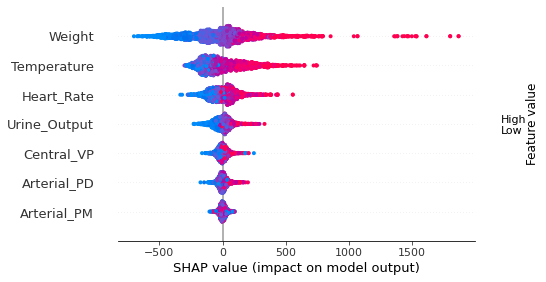

In [485]:
explainer = shap.TreeExplainer(random_forest)
shap_values  = explainer.shap_values(x)
shap.summary_plot(shap_values, x)

Feature: Temperature, Score: 0.21450
Feature: Urine_Output, Score: 0.08710
Feature: Heart_Rate, Score: 0.13810
Feature: Central_VP, Score: 0.09179
Feature: Arterial_PD, Score: 0.07259
Feature: Arterial_PM, Score: 0.06834
Feature: Weight, Score: 0.32758


<BarContainer object of 7 artists>

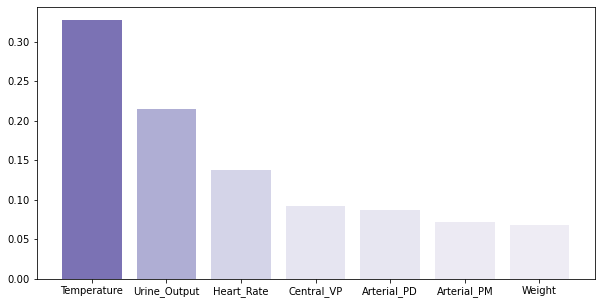

In [448]:
features = pd.Series(random_forest.feature_importances_).sort_values(ascending=False)
for i in range(len(features)):
    print('Feature: %0s, Score: %.5f' % (x_train.columns[i],features[i]))
# Create a bar plot
fig, ax = plt.subplots()
plt.gcf().set_size_inches(10,5)
ax.bar(x_train.columns, features, color=plt.cm.Purples(features.values*2))

# Gradient Boosting Regression

In [451]:
gradient_boosting = GradientBoostingRegressor()
gradient_boosting.fit(x_train, y_train)
y_pred = gradient_boosting.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
print("Gradient Boosting Regression MSE: ", mse)
print("Gradient Boosting Regression R2: ", r2)
print("Gradient Boosting Regression MAE: ", mae)
print("Gradient Boosting Regression EVS: ", evs)

Gradient Boosting Regression MSE:  158248.34313274676
Gradient Boosting Regression R2:  0.3696296727522732
Gradient Boosting Regression MAE:  307.61364988444416
Gradient Boosting Regression EVS:  0.370056412460796


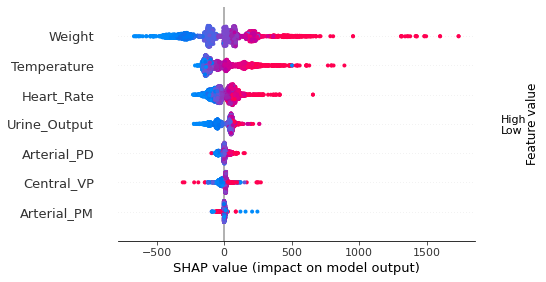

In [488]:
explainer = shap.TreeExplainer(gradient_boosting)
shap_values  = explainer.shap_values(x)
shap.summary_plot(shap_values, x)

Feature: Temperature, Score: 0.22758
Feature: Urine_Output, Score: 0.06372
Feature: Heart_Rate, Score: 0.11500
Feature: Central_VP, Score: 0.03517
Feature: Arterial_PD, Score: 0.01941
Feature: Arterial_PM, Score: 0.01193
Feature: Weight, Score: 0.52718


<BarContainer object of 7 artists>

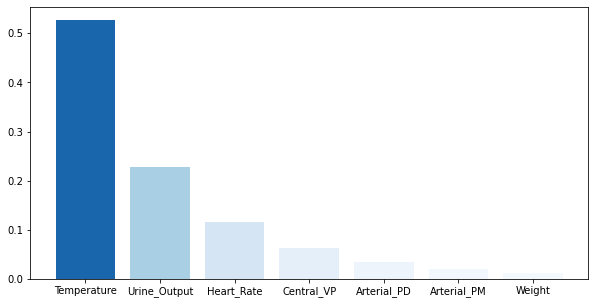

In [452]:
features = pd.Series(gradient_boosting.feature_importances_).sort_values(ascending=False)
# Create a bar plot
for i in range(len(features)):
    print('Feature: %0s, Score: %.5f' % (x_train.columns[i],features[i]))
fig, ax = plt.subplots()
plt.gcf().set_size_inches(10,5)
ax.bar(x_train.columns, features, color=plt.cm.Blues(features.values*1.5))

# MLP Regressor

In [453]:
mlp = MLPRegressor()
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
print("MLPRegressor Regression MSE: ", mse)
print("MLPRegressor Regression R2: ", r2)
print("MLPRegressor Regression MAE: ", mae)
print("MLPRegressor Regression EVS: ", evs)

MLPRegressor Regression MSE:  176836.1133112177
MLPRegressor Regression R2:  0.29558669360790846
MLPRegressor Regression MAE:  334.69030914265466
MLPRegressor Regression EVS:  0.2970916923387493


C:\Users\oritre\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
